# Hurricane Detection Heatmap Generation Prototyping


In [78]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
% matplotlib inline
import os
import time
import pandas as pd

In [83]:
'''select which dataset to use'''
DATA_CHOICE = ['2channel', '3channel'][1]

if DATA_CHOICE == '2channel':
    work_dir = 'detection_cnn_lr_2ch/'
    data_dir = 'heatmap_data'
    input_file_name = 'hurricane_heatmap_input_2channels.npy'
    ckpt_file = 'model/model_1/model_1'
    window = 10    
elif DATA_CHOICE == '3channel':
    work_dir = 'detection_cnn_hr_3ch/'
    data_dir = 'heatmap_data'
    input_file_name = 'hurricane_heatmap_input_3channels.npy'
    ckpt_file = 'model/nopool3_aug/nopool3_aug'
    window = 40    
else:
    raise ValueError

path_to_data = os.path.join(work_dir, data_dir)
input_file = os.path.join(work_dir, data_dir, input_file_name)
ckpt_file = os.path.join(work_dir, ckpt_file)
print(work_dir)
print(path_to_data)
print(input_file)
print(ckpt_file)

detection_cnn_hr_3ch/
detection_cnn_hr_3ch/heatmap_data
detection_cnn_hr_3ch/heatmap_data/hurricane_heatmap_input_3channels.npy
detection_cnn_hr_3ch/model/nopool3_aug/nopool3_aug


In [84]:
all_heatmap = np.load(ckpt_file + '_heatmap_test.npy', mmap_mode='r')

In [85]:
'''load true hurricane position'''
output=np.load(os.path.join(work_dir, data_dir, 'hurricane_heatmap_location_lonlat.npy'))
index=777
# inn=img[index,:,:,1]

_, d1,d2=np.shape(all_heatmap)

lat_resol=120.0/d1; lon_resol=360.0/d2;
print(lat_resol,lon_resol)

l_true_label = []

for k in range(len(output[index])):
    lat_index=(40.0+float((output[index][k].split(",")[1]).split(")")[0]))/lat_resol;
    lon_index=float((output[index][k].split(",")[0]).split("(")[1])/lon_resol;
    l_true_label.append((lon_index, lat_index))
    print(str(k)+" (lon,lat) :",output[index][k])
    print(str(k)+" (lon_index, lat_index) :",lon_index, lat_index)

0.23483365949119372 0.3125
0 (lon,lat) : (134.685066,34.547997)
0 (lon_index, lat_index) : 430.99221120000004 317.4502205583334
1 (lon,lat) : (128.729447,20.853316)
1 (lon_index, lat_index) : 411.9342304 259.1337039666667
2 (lon,lat) : (247.805787,16.149786)
2 (lon_index, lat_index) : 792.9785184 239.10450538333333


In [86]:
'''load predicted hurricane position'''
df_pred_pos = pd.read_csv('nopool3_aug_center_test.csv')

In [87]:
print(len(df_pred_pos))
df_pred_pos.head()

30


,Unnamed: 0,frame,lon_idx,lat_idx
0,0,0,42,392
1,1,0,24,263
2,2,0,38,771
3,3,0,19,1028
4,4,0,37,400


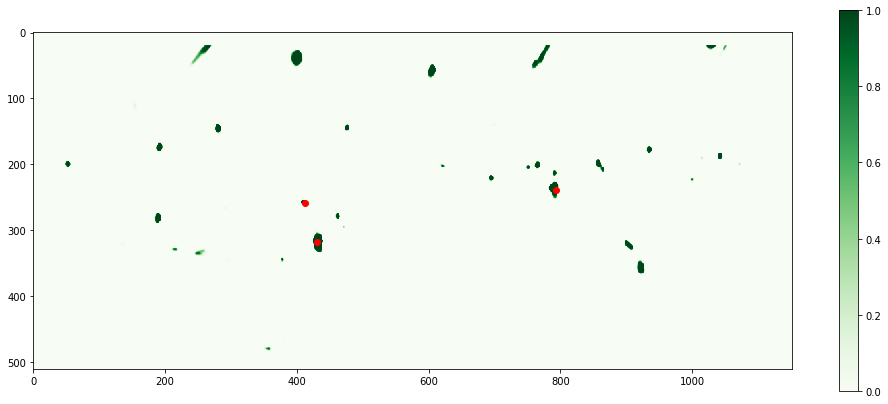

In [95]:
plt.figure(figsize=(17,7))
plt.imshow(all_heatmap[0,:,:], cmap='Greens')
plt.colorbar()

for t in l_true_label:
    plt.scatter([t[0]], [t[1]], c='r')
    
# for i, row in df_pred_pos.iterrows():
#     lon_idx = row['lon_idx']
#     lat_idx = row['lat_idx']
#     plt.scatter([lat_idx], [lon_idx], c='b')

In [15]:
a = np.array([[1,2,3],[4,5,6]])

In [16]:
a

array([[1, 2, 3],
       [4, 5, 6]])

In [18]:
a[:,::-1]

array([[3, 2, 1],
       [6, 5, 4]])

(12577, 511, 1152, 3)


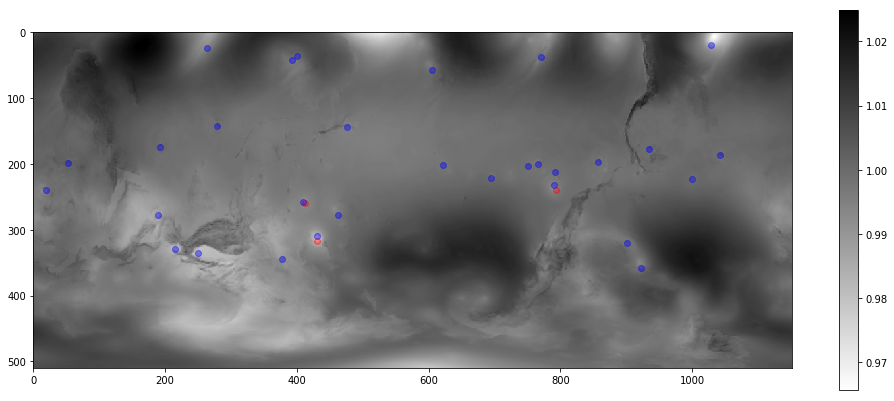

In [100]:
plt.figure(figsize=(17,7))
img = np.load(input_file, mmap_mode='r')  # time, lat, lon, chan
print(img.shape)
_, imgd2, imgd3, imgd4 = img.shape
# plt.imshow(np.clip(img[777,:,:,0], 0, 30))
plt.imshow(img[777,:,:,2], cmap='binary')
plt.colorbar()

for t in l_true_label:
    plt.scatter([t[0]], [t[1]], c='r', alpha=0.4)
    
for i, row in df_pred_pos.iterrows():
    lon_idx = row['lon_idx']
    lat_idx = row['lat_idx']
    plt.scatter([lat_idx], [lon_idx], c='b', alpha=0.4)

In [12]:
max_ = np.load(os.path.join(work_dir, data_dir, 'max.npy'))
min_ = np.load(os.path.join(work_dir, data_dir, 'min.npy'))

MemoryError: 

## loading model

In [4]:
saver = tf.train.import_meta_graph(ckpt_file+'.meta')
sess = tf.Session()
saver.restore(sess, ckpt_file)

'''placeholders for conv'''
img_input = tf.get_collection('img_input')[0]
pred_y_map = tf.get_collection('pred_y_map')[0]
keep_prob = tf.get_collection('keep_prob')[0]

'''placeholders for sliding window'''
input_x = tf.get_collection('crop_input')[0]
pred_y = tf.get_collection('crop_pred')[0]

INFO:tensorflow:Restoring parameters from detection_cnn_hr_3ch/model/minmax/minmax


## Sliding window

In [5]:
_, n_lat, n_lon, _ = img.shape

In [14]:
win_size = window
img_idx = 777
offset = int(win_size/2)
time_s = time.time()
result_map = np.zeros((n_lat, n_lon))
for lat_idx in range(n_lat-win_size):
    for lon_idx in range(n_lon-win_size):
        window_crop = img[img_idx:img_idx+1, lat_idx:lat_idx+win_size, lon_idx:lon_idx+win_size, :]
        
        window_crop = (window_crop - min_) / (max_ - min_)
        
        out = sess.run(pred_y, feed_dict={input_x: window_crop,
                                          keep_prob: 1.0})
        result_map[lat_idx + offset, lon_idx + offset] = out[0]
elapsed = time.time() - time_s
print('{:.3f}'.format(elapsed))

585.277


In [15]:
'''thresholding'''
result_map_thres = result_map.copy()
result_map_thres[result_map_thres <= 0.8] = 0.

0.23483365949119372 0.3125
0 (lon,lat) : (134.685066,34.547997)
0 (lon_index, lat_index) : 430.99221120000004 317.4502205583334
1 (lon,lat) : (128.729447,20.853316)
1 (lon_index, lat_index) : 411.9342304 259.1337039666667
2 (lon,lat) : (247.805787,16.149786)
2 (lon_index, lat_index) : 792.9785184 239.10450538333333


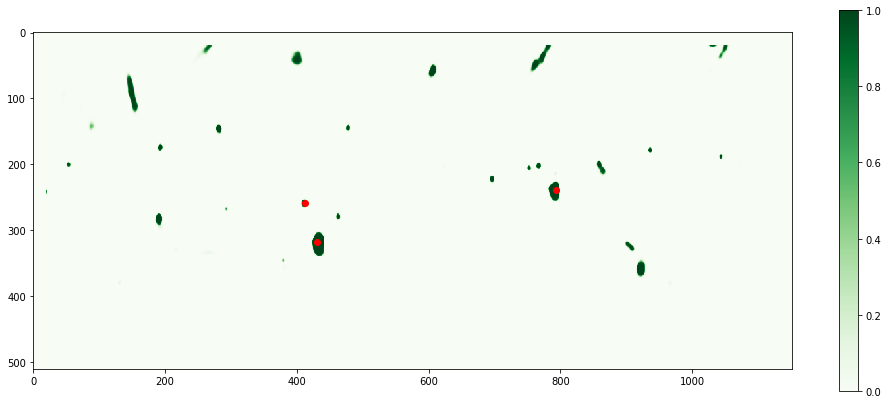

In [18]:
plt.figure(figsize=(17,7))
plt.imshow(result_map, cmap='Greens')
plt.colorbar()

for t in l_true_label:
    plt.scatter([t[0]], [t[1]], c='r')

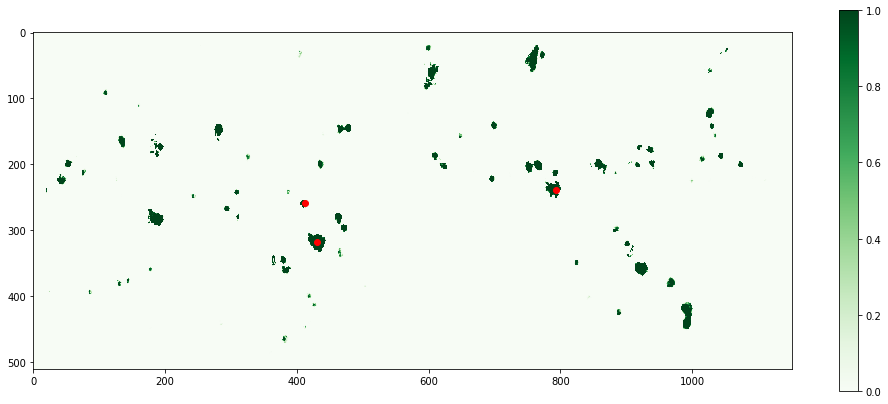

In [33]:
plt.figure(figsize=(17,7))
plt.imshow(result_map, cmap='Greens')
plt.colorbar()

for t in l_true_label:
    plt.scatter([t[0]], [t[1]], c='r')

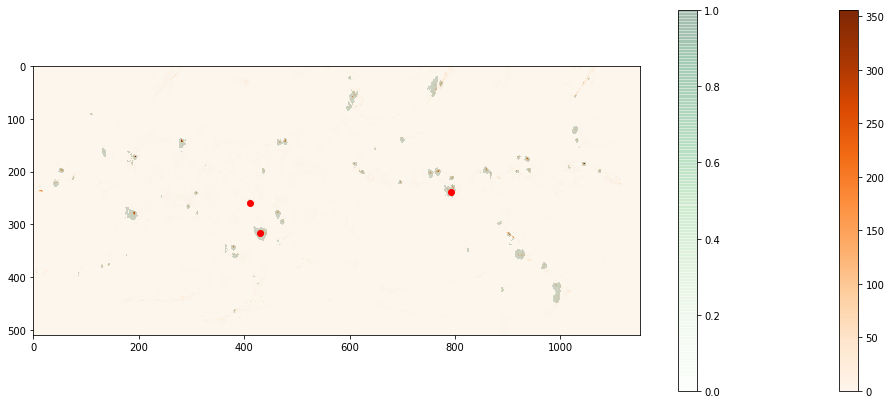

In [39]:
plt.figure(figsize=(17,7))
plt.imshow(img[img_idx,:,:,0], alpha=1., cmap='Oranges')
plt.colorbar()
plt.imshow(result_map_thres, alpha=0.2, cmap='Greens')
plt.colorbar()
for t in l_true_label:
    plt.scatter([t[0]], [t[1]], c='r')

In [4]:
_, n_lat, n_lon, _ = img.shape

In [7]:
win_size = window
img_idx = 777
offset = int(win_size/2)
time_s = time.time()
result_map = np.zeros((n_lat, n_lon))
for lat_idx in range(n_lat-win_size):
    for lon_idx in range(n_lon-win_size):
        window_crop = img[img_idx:img_idx+1, lat_idx:lat_idx+win_size, lon_idx:lon_idx+win_size, :]
        out = sess.run(pred_y, feed_dict={input_x: window_crop,
                                          keep_prob: 1.0})
        result_map[lat_idx + offset, lon_idx + offset] = out[0]
elapsed = time.time() - time_s
print('{:.3f}'.format(elapsed))

480.154


In [17]:
'''thresholding'''
result_map_thres = result_map.copy()
result_map_thres[result_map_thres <= 0.8] = 0.

In [11]:
'''load true hurricane position'''
output=np.load(os.path.join(work_dir, data_dir, 'hurricane_heatmap_location_lonlat.npy'))
index=777
inn=img[index,:,:,1]

d1,d2=np.shape(inn)

lat_resol=120.0/d1; lon_resol=360.0/d2;
print(lat_resol,lon_resol)

l_true_label = []

for k in range(len(output[index])):
    lat_index=(40.0+float((output[index][k].split(",")[1]).split(")")[0]))/lat_resol;
    lon_index=float((output[index][k].split(",")[0]).split("(")[1])/lon_resol;
    l_true_label.append((lon_index, lat_index))
    print(str(k)+" (lon,lat) :",output[index][k])
    print(str(k)+" (lon_index, lat_index) :",lon_index, lat_index)

0.23483365949119372 0.3125
0 (lon,lat) : (134.685066,34.547997)
0 (lon_index, lat_index) : 430.99221120000004 317.4502205583334
1 (lon,lat) : (128.729447,20.853316)
1 (lon_index, lat_index) : 411.9342304 259.1337039666667
2 (lon,lat) : (247.805787,16.149786)
2 (lon_index, lat_index) : 792.9785184 239.10450538333333


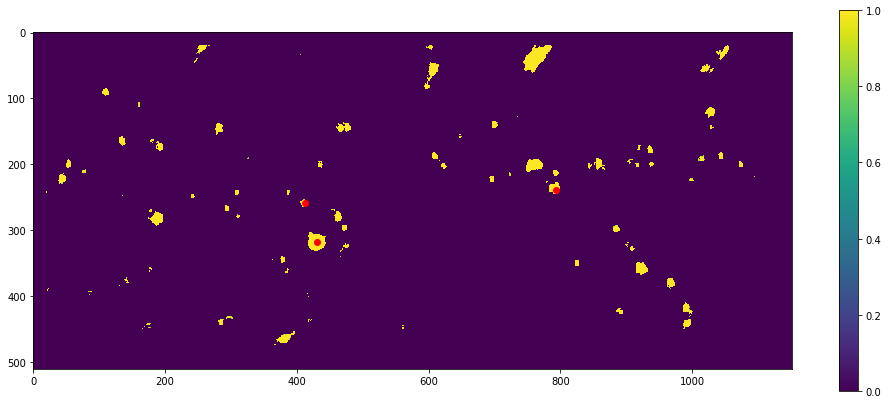

In [12]:
plt.figure(figsize=(17,7))
plt.imshow(result_map_thres[:,:])
plt.colorbar()

for t in l_true_label:
    plt.scatter([t[0]], [t[1]], c='r')

## CONV

In [13]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
% matplotlib inline

In [59]:
heatmap_file = 'detection_cnn_hr_3ch/model/nopool/nopool_heatmap_700_100.npy'
all_heatmap = np.load(heatmap_file)

In [69]:
n_heatmap, h_size, w_size = all_heatmap.shape

In [73]:
WW, HH = np.meshgrid(np.arange(w_size), np.arange(h_size))  # index matrix

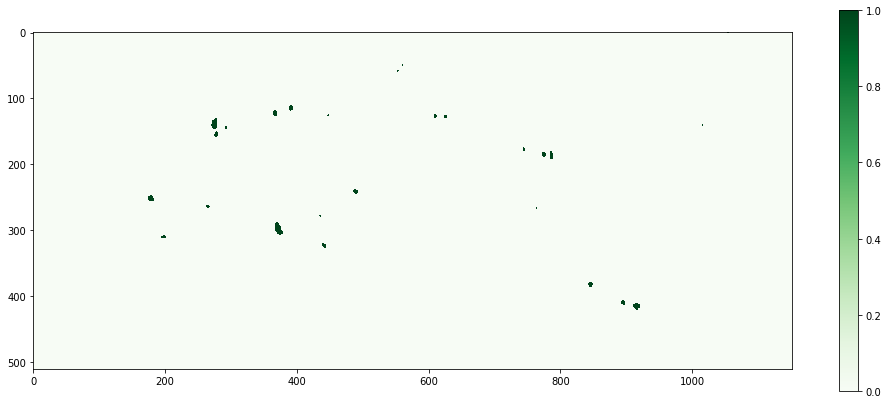

In [34]:
plt.figure(figsize=(17,7))
plt.imshow(a[5,:,:]>0.8, cmap='Greens')
plt.colorbar()

In [38]:
from skimage import measure

In [62]:
heatmap = all_heatmap[0, :,:]
thresholded = (heatmap > 0.8).astype('int')
conn, num = measure.label(thresholded, connectivity=2, return_num=True)


In [75]:
component_idx = 1
component_h = HH[conn==component_idx]
component_w = WW[conn==component_idx]
probs = heatmap[conn==component_idx]
max_idx = np.argmax(probs)
center_h = component_h[max_idx]
center_w = component_w[max_idx]

In [76]:
print(center_h, center_w)

0 1044


In [66]:
XX.shape

(1152, 511)

In [67]:
heatmap.shape

(511, 1152)

In [45]:
num

35

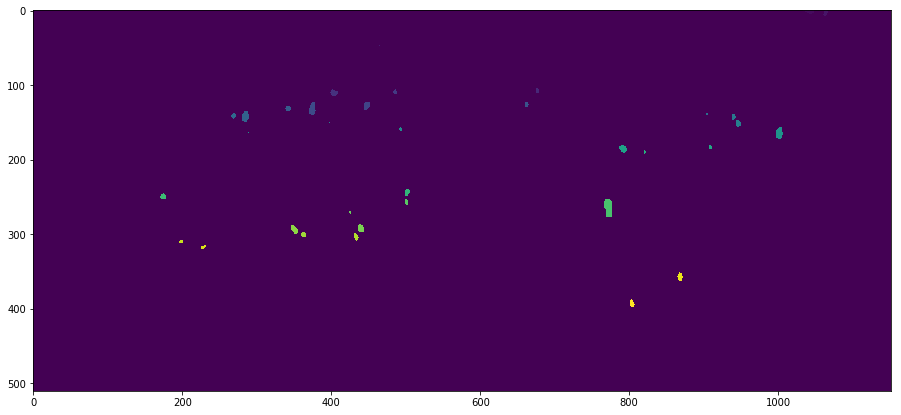

In [43]:
plt.figure(figsize=(17,7))
plt.imshow(conn)

In [47]:
conn==1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

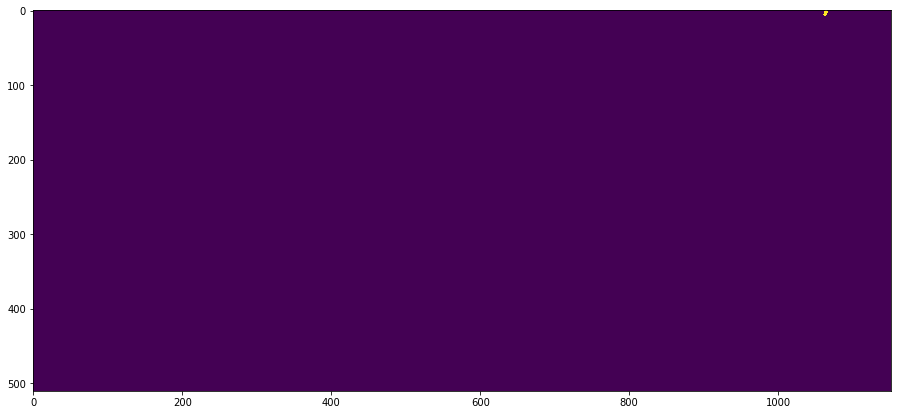

In [49]:
plt.figure(figsize=(17,7))
plt.imshow(conn==2)

In [53]:
a[0][conn==1]

array([ 0.92864919,  0.98330587,  0.99573249,  0.99878019,  0.99957448,
        0.99980289,  0.99989545,  0.99994326,  0.99997139,  0.99998438,
        0.99998844,  0.99998176,  0.99991512,  0.99887282,  0.96589869,
        0.87260896,  0.97003216,  0.99200726,  0.99759609,  0.99903452,
        0.9995302 ,  0.99976927,  0.99988389,  0.99993956,  0.99995208,
        0.99991786,  0.99965906,  0.99657154,  0.92857969,  0.92651516,
        0.97589898,  0.99116057,  0.99645507,  0.99840671,  0.99921656,
        0.9995572 ,  0.99965   ,  0.99941909,  0.99789113,  0.98328078,
        0.88852197,  0.95309043,  0.98056567,  0.99131167,  0.99521059,
        0.99583483,  0.99350667,  0.98133194,  0.89301503,  0.85381615,
        0.91238338,  0.92582214,  0.89784491])

In [29]:
a[0, 100:410,100:250].argmax()

22574

In [13]:
# pred_img = sess.run(pred_y_map, feed_dict= {img_input:img[[400]], keep_prob:1})

In [14]:
# plt.figure(figsize=(16,9))
# plt.imshow(pred_img[0,:,:,0])
# plt.colorbar()